# Projection data and encoding

In this notebook, we will walk through the projection data and how we might encode the player identifier so we can use a single regression model for player projections.

In [1]:
import datetime
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from nbaspa.data.endpoints import AllPlayers, PlayerInfo
from nbaspa.data.endpoints.parameters import Season, SEASONS, CURRENT_SEASON, CURRENT_SEASON_YEAR
from nbaspa.data.factory import NBADataFactory
from nbaspa.projections.encoder import BayesianTargetEncoder

## Loading data

In [2]:
PROJECTION_SEASON_START = Season(2007)  # We need 2006-07 ratings to encode
PROJECTION_SEASON_END = Season(2019)  # No covid pls

In [3]:
loader = AllPlayers(
    output_dir=Path(os.environ["DATA_DIR"], CURRENT_SEASON),
    Season=CURRENT_SEASON
)
loader.load()

In [4]:
playerinfo = loader.get_data()
playerinfo.drop_duplicates(subset="PERSON_ID", keep="first", inplace=True)
playerinfo["TO_YEAR"] = playerinfo["TO_YEAR"].astype(int)
playerinfo.loc[playerinfo["TO_YEAR"] == int(CURRENT_SEASON_YEAR), "TO_YEAR"] = PROJECTION_SEASON_END.year
playerinfo["FROM_YEAR"] = playerinfo["FROM_YEAR"].astype(int)

playerinfo = playerinfo[
    (playerinfo["TO_YEAR"] >= (PROJECTION_SEASON_START - 1).year)
    & (playerinfo["TO_YEAR"] - np.maximum(playerinfo["FROM_YEAR"], (PROJECTION_SEASON_START - 1).year) >= 4)
].copy()

Loop through each player and get their impact summary as well as demographic information

In [5]:
calls = [
    ("PlayerInfo", {"PlayerID": row.PERSON_ID}) for _, row in playerinfo.iterrows()
]
birthdate_loader = NBADataFactory(calls=calls, output_dir=os.environ["DATA_DIR"])
_ = birthdate_loader.load()

|████████████████████████████████████████| 642/642 [100%] in 1.3s (482.91/s)
We have 388 eligible players
|████████████████████████████████████████| 388/388 [100%] in 2:21.5 (2.74/s)
|████████████████████████████████████████| 388/388 [100%] in 0.2s (1676.85/s)
We have a total of 2548 observations in the training set.


In [6]:
commoninfo = birthdate_loader.get_data("CommonPlayerInfo")
commoninfo["BIRTHDATE"] = pd.to_datetime(commoninfo["BIRTHDATE"])

Load the player impact time-series data. We need to use game-level data because we need variance in the impact to produce an encoding.

In [7]:
dflist = []
for year in range((PROJECTION_SEASON_START - 1).year, (PROJECTION_SEASON_END + 1).year):
    season = Season(year)

    fglob = Path(os.environ["DATA_DIR"], str(season)).glob("impact-plus-timeseries/data_*.csv")
    sublist = []
    for fpath in fglob:
        subdf = pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        subdf = subdf[subdf["IMPACT"] != 0].copy()  # Exactly 0 means player didn't play
        if subdf.shape[0] < 50:  # Removing seasons in which players didn't play much
            continue
        sublist.append(subdf)
    df = pd.concat(sublist, ignore_index=True)
    df["SEASON"] = str(season)
    df["SEASON_START"] = SEASONS[str(season)]["START"]
    dflist.append(df)

seasonratings = pd.concat(dflist, ignore_index=True)
seasonratings["SEASON_START"] = pd.to_datetime(seasonratings["SEASON_START"])
seasonratings["GAME_DATE"] = pd.to_datetime(seasonratings["GAME_DATE"])

In [8]:
ratings_age = pd.merge(
    commoninfo[["DISPLAY_FIRST_LAST", "PERSON_ID", "BIRTHDATE"]],
    seasonratings,
    how="inner",
    left_on="PERSON_ID", right_on="PLAYER_ID"
)[["PLAYER_ID", "TEAM_ID", "PERSON_ID", "DISPLAY_FIRST_LAST", "BIRTHDATE", "GAME_DATE", "SEASON", "SEASON_START", "IMPACT"]]

We roughly checked for 4+ seasons of data before but let's verify and filter again.

In [9]:
grouped_ = ratings_age.groupby(["PLAYER_ID", "SEASON"]).mean().reset_index().groupby("PLAYER_ID")
counts_ = grouped_.count()["SEASON"]
ratings_age = ratings_age[ratings_age["PLAYER_ID"].isin(counts_[counts_ >= 4].index)].copy()

In [10]:
print(f"We have {len(counts_[counts_ >= 4])} eligible players")

In [11]:
ratings_age["AGE"] = (ratings_age["SEASON_START"] - ratings_age["BIRTHDATE"]) / np.timedelta64(1, "Y")

## Encoding player-level information

To use a single regression model and retain player-level projections, we need to encode some information about each player in the training dataset. However, traditional methods such as one-hot encoding have a few drawbacks:

1. **High cardinality**: Hundreds of players means that one-hot encoding will introduce hundreds of sparse (mostly 0) columns.
2. **Refitting**: When new players are introduced into the pool, we will have to retrain the projection model entirely as the shape of the training data has changed.

So, we would like to create an encoding for player ID that doesn't result in hundreds of new columns that hardcode the training dataset. Since we want to introduce a numeric relationship between the players, we will be leveraging some sort of *ordinal encoding*. At first, we thought about *target encoding*, where the player identifier is converted to the average impact for all of that player's games. The problem with target encoding is overfitting. There are other target encoding methods that aim to solve this problem (e.g. James-Stein encoding), but most of these methods rely on the assumption that impact is normally distributed.

### Bayesian target encoding

#### Refresher on Bayesian statistics

In bayesian statstics, we have

$$p(\theta | y) = \frac{p(y | \theta)p(\theta)}{p(y)}$$

where $p(\theta)$ is the *prior distribution* for parameter $\theta$, $p(y|\theta)$ is the *likelihood* of $y$ given $\theta$, and $p(\theta|y)$ is the *posterior distribution* of parameter $\theta$ using $y$. In particular, we will focus on *conjugate Bayesian models*, where the prior distribution and posterior distribution of $\theta$ are from the same family.

##### Example

Consider a situation where the target variable in our dataset is binary. This means that $y_{1}, ..., y_{n}$ are independent and identically distributed from a Bernoulli process where $\theta$, the probability of a 1, is **unknown**.

Using [Fink's Compendium of conjugate priors](https://www.johndcook.com/CompendiumOfConjugatePriors.pdf), the prior distribution of $\theta$ is a Beta distribution with **hyperparameters** $\alpha$ and $\beta$. i.e., $\theta \sim Beta(\alpha, \beta)$

$$p(\theta) = p(\theta|\alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}p^{\alpha - 1}(1 - p)^{\beta - 1}, 0 < p < 1$$

Since we are using a conjugate Bayesian model, the posterior distribution $p(\theta | y)$ follows a $Beta(\alpha^{\prime}, \beta^{\prime})$. Fink stipulates that 

$$ \alpha^{\prime} = \alpha + \sum_{i = 1}^{n} y_{i}$$

and

$$ \beta^{\prime} = \beta + n - \sum_{i = 1}^{n} y_{i} $$

#### Procedure

Ok, let's lay out the procedure for bayesian target encoding. Suppose you have $n$ training observations, with $Y = (y_{1}, ..., y_{n})$ representing the target and categorical variable $X_{1} = (x_{1}, ..., x_{n})$ with distinct values $V = (v_{1}, ..., v_{l})$.

1. Observe and choose a likelihood for $Y$ (e.g. Bernoulli),
2. Derive the prior distribution for the likelihood parameter(s) (e.g. Beta),
3. Use the training data to initialize the prior distribution hyperparameters (e.g. $\alpha$ and $\beta$),
    1. **NOTE**: This process is generally reliant on common interpretations of the hyperparameters
4. Derive the method for generating the posterior distribution (e.g. computing $\alpha^{\prime}$ and $\beta^{\prime}$),
5. For each level $v_{i} \in V$,
    1. Generate the posterior distribution using $y_{1}, ..., y_{m} | x_{j} = v_{i}, \forall j \in (1, m)$,
    2. Set the encoding value(s) for $v_{i}$ as a sample from the posterior distribution (e.g. sample $Beta(\alpha^{\prime}, \beta^{\prime})$)
        1. **NOTE**: The number of output columns representing $X_{1}$ depends on the number of parameters in the likelihood. Practically speaking, we might choose to fix parameters for a given likelihood function and only update one.

We will then repeat step 5.B $K$ times, generating a total of $K$ training datasets with unique encodings. Our end model will be comprised of $K$ submodels trained on each sampled dataset. The model prediction will be an average of the outputs from each submodel.

### Applying the bayesian encoder to the player rating data

Let's examine game-level impact ratings to determine a likelihood function for impact.

In [12]:
transformer = MinMaxScaler(feature_range=(0, 3))
ratings_age["IMPACT_SCALED"] = transformer.fit_transform(ratings_age[["IMPACT"]])

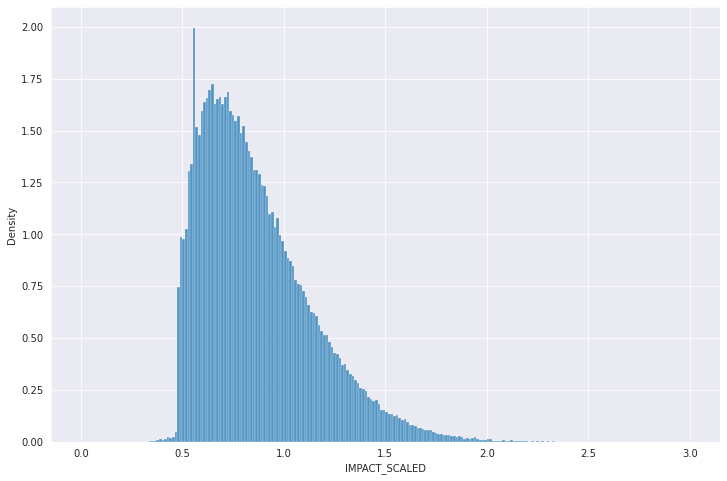

In [13]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(x="IMPACT_SCALED", data=ratings_age, stat="density", ax=ax)

This is not not normally distributed. Let's fit a few different distributions using ``scipy``.

In [14]:
dists = ["gamma", "invgamma"]

dflist = []
for dist in dists:
    # Fit the distribution
    params = getattr(scipy.stats, dist).fit(ratings_age["IMPACT_SCALED"])
    x = np.linspace(
        getattr(scipy.stats, dist).ppf(0.01, *params),
        getattr(scipy.stats, dist).ppf(0.99, *params)
    )
    random_var = getattr(scipy.stats, dist)(*params)
    y = random_var.pdf(x)
    dflist.append(
        pd.DataFrame({"x": x, "y": y, "dist": dist})
    )

dist_df = pd.concat(dflist, ignore_index=True)

/usr/local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


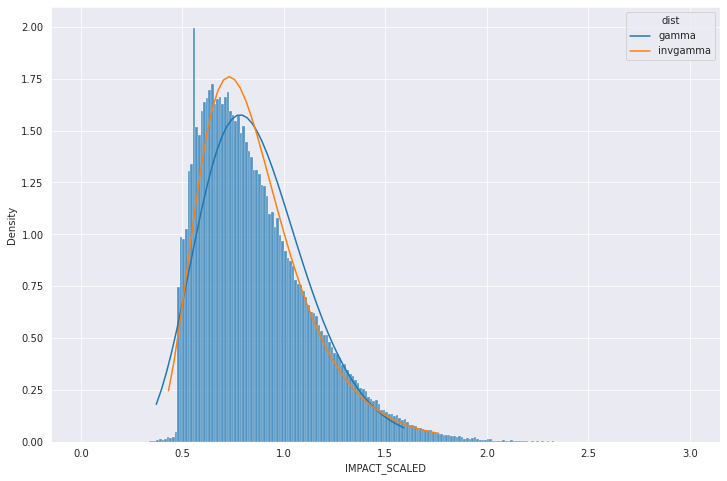

In [15]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(x="IMPACT_SCALED", data=ratings_age, stat="density", ax=ax)
    sns.lineplot(x="x", y="y", hue="dist", data=dist_df, ax=ax)

For our bayesian encoder, we'll use an inverse gamma distribution.

In [16]:
encoder = BayesianTargetEncoder(dist="invgamma")
encoder_out = encoder.fit_transform(ratings_age[["PERSON_ID"]], ratings_age["IMPACT_SCALED"])

/usr/local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [17]:
ratings_age["PERSON_ID"] = encoder_out

In [18]:
agg = ratings_age.groupby(
    ["PLAYER_ID", "AGE", "SEASON", "SEASON_START"]
)[["IMPACT", "IMPACT_SCALED", "PERSON_ID"]].mean()

In [19]:
agg.reset_index(inplace=True)

In [20]:
agg = agg[agg["SEASON_START"] >= SEASONS[str(PROJECTION_SEASON_START)]["START"]].copy()

In [21]:
print(f"We have a total of {agg.shape[0]} observations in the training set.")

Let's graph career average impact against the encoding to ensure there's at least some correlation. The correlation won't be perfect because, based on how many games each player has played, they will affect the posterior distribution differently.

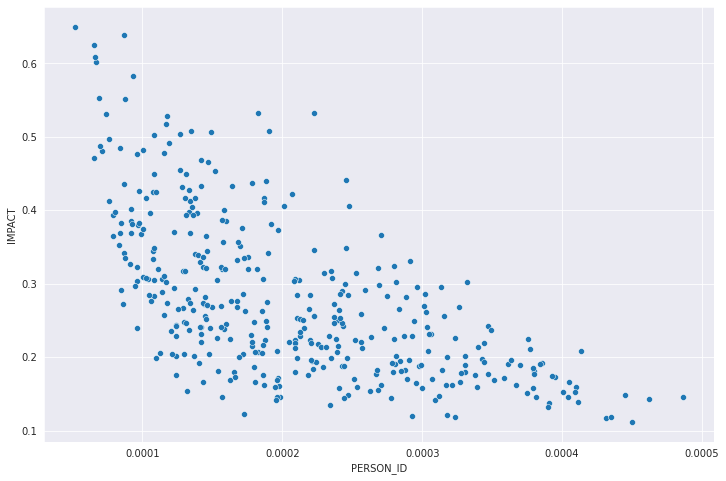

In [22]:
mydf = agg.groupby("PLAYER_ID")[["IMPACT", "PERSON_ID"]].mean()
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.scatterplot(x="PERSON_ID", y="IMPACT", data=mydf, ax=ax)